## 1. Imports and Setup

In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
import torchvision.models as models

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [2]:
# Configuration
DATA_DIR = '../data'
IMAGES_DIR = os.path.join(DATA_DIR, 'Images')
CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions.txt')
MODELS_DIR = '../models'

# Hyperparameters
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 3e-4
MIN_WORD_FREQ = 5  # Words appearing less than this are replaced with <UNK>

## 2. Data Loading

In [3]:
# Load captions data
df = pd.read_csv(CAPTIONS_FILE)
print(f'Total caption entries: {len(df)}')
print(f'Unique images: {df["image"].nunique()}')
print(f'\nSample data:')
df.head(10)

Total caption entries: 40455
Unique images: 8091

Sample data:


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [4]:
# Clean captions
def clean_caption(caption):
    """Clean and preprocess caption text."""
    caption = caption.lower()
    caption = ''.join(c for c in caption if c.isalpha() or c.isspace())
    caption = ' '.join(caption.split())  # Remove extra spaces
    return caption

df['cleaned_caption'] = df['caption'].apply(clean_caption)
df.head()

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,a little girl in a pink dress going into a woo...


In [5]:
class Vocabulary:
    """Vocabulary class for mapping words to indices and vice versa."""
    
    def __init__(self, min_freq=5):
        self.min_freq = min_freq
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = Counter()
        
        # Special tokens
        self.pad_token = '<PAD>'
        self.start_token = '<START>'
        self.end_token = '<END>'
        self.unk_token = '<UNK>'
        
    def build_vocabulary(self, captions):
        """Build vocabulary from list of captions."""
        # Count word frequencies
        for caption in captions:
            for word in caption.split():
                self.word_freq[word] += 1
        
        # Add special tokens
        for idx, token in enumerate([self.pad_token, self.start_token, self.end_token, self.unk_token]):
            self.word2idx[token] = idx
            self.idx2word[idx] = token
        
        # Add words that meet minimum frequency
        idx = len(self.word2idx)
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        print(f'Vocabulary size: {len(self.word2idx)}')
        print(f'Words below min_freq ({self.min_freq}): {sum(1 for f in self.word_freq.values() if f < self.min_freq)}')
    
    def encode(self, caption):
        """Convert caption string to list of indices."""
        tokens = [self.word2idx[self.start_token]]
        for word in caption.split():
            tokens.append(self.word2idx.get(word, self.word2idx[self.unk_token]))
        tokens.append(self.word2idx[self.end_token])
        return tokens
    
    def decode(self, indices):
        """Convert list of indices back to caption string."""
        words = []
        for idx in indices:
            word = self.idx2word.get(idx, self.unk_token)
            if word == self.end_token:
                break
            if word not in [self.start_token, self.pad_token]:
                words.append(word)
        return ' '.join(words)
    
    def __len__(self):
        return len(self.word2idx)

In [6]:
# Build vocabulary
vocab = Vocabulary(min_freq=MIN_WORD_FREQ)
vocab.build_vocabulary(df['cleaned_caption'].tolist())

# Test encoding/decoding
test_caption = df['cleaned_caption'].iloc[0]
print(f'Original: {test_caption}')
encoded = vocab.encode(test_caption)
print(f'Encoded: {encoded}')
decoded = vocab.decode(encoded)
print(f'Decoded: {decoded}')

Vocabulary size: 2988
Words below min_freq (5): 5794
Original: a child in a pink dress is climbing up a set of stairs in an entry way
Encoded: [1, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 3, 16, 2]
Decoded: a child in a pink dress is climbing up a set of stairs in an <UNK> way


In [7]:
# Train/validation split (use one caption per image for simplicity, keep 5 for training variety)
unique_images = df['image'].unique()
np.random.shuffle(unique_images)

train_size = int(0.9 * len(unique_images))
train_images = set(unique_images[:train_size])
val_images = set(unique_images[train_size:])

train_df = df[df['image'].isin(train_images)].reset_index(drop=True)
val_df = df[df['image'].isin(val_images)].reset_index(drop=True)

print(f'Training samples: {len(train_df)} ({len(train_images)} images)')
print(f'Validation samples: {len(val_df)} ({len(val_images)} images)')

Training samples: 36405 (7281 images)
Validation samples: 4050 (810 images)


In [8]:
class CaptionDataset(Dataset):
    """Custom Dataset for image captioning."""
    
    def __init__(self, dataframe, images_dir, vocab, transform=None):
        self.df = dataframe
        self.images_dir = images_dir
        self.vocab = vocab
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load and transform image
        img_path = os.path.join(self.images_dir, row['image'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Encode caption
        caption = self.vocab.encode(row['cleaned_caption'])
        caption = torch.tensor(caption, dtype=torch.long)
        
        return image, caption


def collate_fn(batch):
    """Custom collate function to pad captions to same length."""
    images, captions = zip(*batch)
    
    # Stack images
    images = torch.stack(images, dim=0)
    
    # Pad captions
    captions = pad_sequence(captions, batch_first=True, padding_value=0)
    
    return images, captions

In [9]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = CaptionDataset(train_df, IMAGES_DIR, vocab, transform)
val_dataset = CaptionDataset(val_df, IMAGES_DIR, vocab, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_fn, num_workers=0)

print(f'Train batches: {len(train_loader)}')
print(f'Val batches: {len(val_loader)}')

Train batches: 1138
Val batches: 127


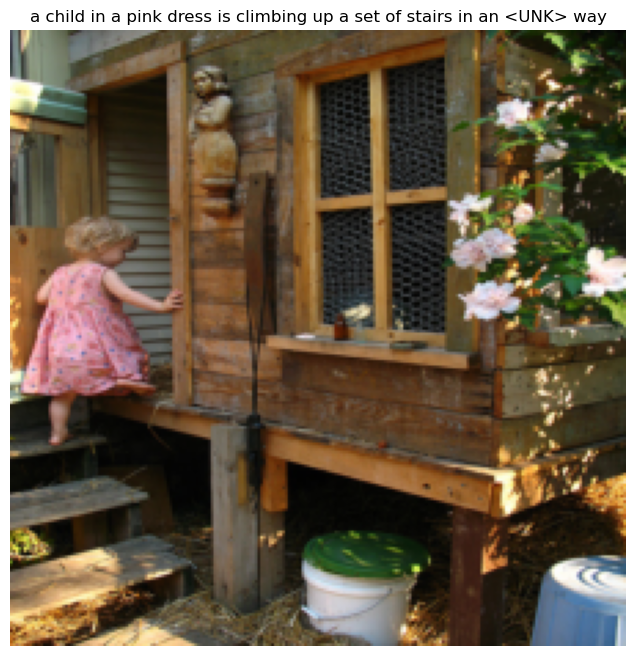

In [10]:
# Visualize a sample
def show_sample(dataset, idx):
    image, caption = dataset[idx]
    
    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_display = image * std + mean
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_display)
    plt.title(vocab.decode(caption.tolist()))
    plt.axis('off')
    plt.show()

show_sample(train_dataset, 0)

## 3. Model Definition

In [11]:
class EncoderCNN(nn.Module):
    """CNN Encoder using pre-trained ResNet50."""
    
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        
        # Load pre-trained ResNet50
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Remove the final classification layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Freeze ResNet parameters (optional, can unfreeze for fine-tuning)
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Linear layer to project features to embed_size
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        
    def forward(self, images):
        # Extract features
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        
        # Project to embedding space
        features = self.fc(features)
        features = self.bn(features)
        
        return features


class DecoderRNN(nn.Module):
    """LSTM Decoder for caption generation."""
    
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, dropout=0.5):
        super(DecoderRNN, self).__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        # Word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        
        # LSTM
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features, captions):
        """
        Forward pass for training.
        features: (batch_size, embed_size) - encoded image features
        captions: (batch_size, seq_length) - target captions
        """
        # Embed captions (exclude last token for input)
        embeddings = self.embedding(captions[:, :-1])  # (batch, seq_len-1, embed_size)
        
        # Prepend image features as first input
        features = features.unsqueeze(1)  # (batch, 1, embed_size)
        embeddings = torch.cat([features, embeddings], dim=1)  # (batch, seq_len, embed_size)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(embeddings)
        lstm_out = self.dropout(lstm_out)
        
        # Output predictions
        outputs = self.fc(lstm_out)  # (batch, seq_len, vocab_size)
        
        return outputs
    
    def generate(self, features, max_length=30, temperature=1.0):
        """
        Generate caption for inference.
        features: (1, embed_size) - encoded image features
        """
        generated = []
        
        # Initialize hidden state
        h = torch.zeros(self.num_layers, 1, self.hidden_size).to(features.device)
        c = torch.zeros(self.num_layers, 1, self.hidden_size).to(features.device)
        
        # First input is image features
        x = features.unsqueeze(1)  # (1, 1, embed_size)
        
        for _ in range(max_length):
            lstm_out, (h, c) = self.lstm(x, (h, c))
            output = self.fc(lstm_out.squeeze(1))  # (1, vocab_size)
            
            # Apply temperature and sample
            output = output / temperature
            predicted = output.argmax(dim=1)
            
            generated.append(predicted.item())
            
            # Stop if END token
            if predicted.item() == 2:  # <END> token index
                break
            
            # Next input is predicted word
            x = self.embedding(predicted).unsqueeze(1)
        
        return generated


class ImageCaptioningModel(nn.Module):
    """Complete Image Captioning Model."""
    
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super(ImageCaptioningModel, self).__init__()
        
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs
    
    def generate_caption(self, image, max_length=30, temperature=1.0):
        """Generate caption for a single image."""
        self.eval()
        with torch.no_grad():
            features = self.encoder(image)
            caption_indices = self.decoder.generate(features, max_length, temperature)
        return caption_indices

In [12]:
# Initialize model
model = ImageCaptioningModel(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=len(vocab),
    num_layers=NUM_LAYERS
).to(device)

# Print model summary
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:27<00:00, 3.79MB/s]


ImageCaptioningModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

## 4. Training

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for images, captions in tqdm(dataloader, desc='Training'):
        images = images.to(device)
        captions = captions.to(device)
        
        # Forward pass
        outputs = model(images, captions)
        
        # Calculate loss (outputs: batch x seq x vocab, targets: batch x seq)
        # Reshape for cross entropy: (batch * seq, vocab) vs (batch * seq)
        outputs = outputs.view(-1, outputs.size(-1))
        targets = captions.view(-1)
        
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc='Validating'):
            images = images.to(device)
            captions = captions.to(device)
            
            outputs = model(images, captions)
            
            outputs = outputs.view(-1, outputs.size(-1))
            targets = captions.view(-1)
            
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

: 

In [ ]:
# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')

print('Starting training...')
print('=' * 50)

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch + 1}/{NUM_EPOCHS}')
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Update learning rate
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, os.path.join(MODELS_DIR, 'best_model.pth'))
        print('  -> Best model saved!')

print('\n' + '=' * 50)
print('Training complete!')

Starting training...

Epoch 1/15


Training:  30%|██▉       | 339/1138 [39:58<1:58:27,  8.90s/it]

In [ ]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(MODELS_DIR, 'training_curves.png'), dpi=150)
plt.show()

In [ ]:
# Test generation on a few examples
model.eval()

def visualize_prediction(dataset, idx):
    image, caption = dataset[idx]
    image_tensor = image.unsqueeze(0).to(device)
    
    # Generate caption
    generated_indices = model.generate_caption(image_tensor)
    generated_caption = vocab.decode(generated_indices)
    actual_caption = vocab.decode(caption.tolist())
    
    # Display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_display = image * std + mean
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_display)
    plt.title(f'Actual: {actual_caption}\n\nGenerated: {generated_caption}', fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a few predictions
for i in range(3):
    visualize_prediction(val_dataset, i)

## 5. Save Model

In [ ]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'embed_size': EMBED_SIZE,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LAYERS,
    'vocab_size': len(vocab),
}, os.path.join(MODELS_DIR, 'final_model.pth'))

print(f'Final model saved to {os.path.join(MODELS_DIR, "final_model.pth")}')

In [ ]:
# Save vocabulary
vocab_data = {
    'word2idx': vocab.word2idx,
    'idx2word': vocab.idx2word,
    'min_freq': vocab.min_freq
}

with open(os.path.join(MODELS_DIR, 'vocab.pkl'), 'wb') as f:
    pickle.dump(vocab_data, f)

print(f'Vocabulary saved to {os.path.join(MODELS_DIR, "vocab.pkl")}')

In [ ]:
# Save validation image list for testing
val_images_list = list(val_images)
with open(os.path.join(MODELS_DIR, 'val_images.pkl'), 'wb') as f:
    pickle.dump(val_images_list, f)

print(f'Validation images list saved ({len(val_images_list)} images)')

In [ ]:
print('\nAll artifacts saved:')
print(f'  - {os.path.join(MODELS_DIR, "best_model.pth")}')
print(f'  - {os.path.join(MODELS_DIR, "final_model.pth")}')
print(f'  - {os.path.join(MODELS_DIR, "vocab.pkl")}')
print(f'  - {os.path.join(MODELS_DIR, "val_images.pkl")}')
print(f'  - {os.path.join(MODELS_DIR, "training_curves.png")}')